# Notebook Version 2

I made a condensed, and more flexible notebook from out initial. It contains the same processing, but not ass much intermittent reporting making navigation easier. One can of course add code where additional summary reports or graphics is needed. In addition, if the functions generating these reports are in a separate file, this notebook can stay condensed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency



In [2]:
from helpers import outliers_IQR, outliers_z_score, outliers_min_max, handle_outliers, fix_obesity

In [3]:
diabetes = pd.read_csv('diabetes.csv')

binary_features = ['Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness',
                   'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching',
                   'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia']
cat_features = ['Race',	'Occupation',	'GP']
num_features = ['Age',	'Height',	'Weight',	'Temperature',	'Urination']
one_hot_features = {} # for future use
diabetes.info()
print("Found:", len(cat_features+binary_features+num_features)+1) # +1 for Gender
print("In DS:", diabetes.shape[1]-1) # -1 for target


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 534 non-null    float64
 1   Gender              542 non-null    object 
 2   Race                537 non-null    object 
 3   Occupation          534 non-null    object 
 4   GP                  539 non-null    object 
 5   Height              538 non-null    float64
 6   Weight              541 non-null    float64
 7   Obesity             538 non-null    object 
 8   Temperature         546 non-null    float64
 9   Urination           532 non-null    float64
 10  TCep                546 non-null    object 
 11  Polydipsia          540 non-null    object 
 12  Sudden Weight Loss  530 non-null    object 
 13  Weakness            541 non-null    object 
 14  Polyphagia          544 non-null    object 
 15  Genital Thrush      538 non-null    object 
 16  Visual B

## Uniform formatting

In [4]:

# Converts all binary features to lower case
for f in binary_features:
   diabetes[f] = diabetes[f].str.lower()

# Converts all binary features to ints, preserving Na-s
diabetes = diabetes.replace({'yes':1, 'no':0}) 
diabetes = diabetes.replace({'Positive':1, 'Negative':0}) 

## Duplicates

We identify duplicates and delete them. We assume they are caused by an error in the data collection, and it's unlikely that there are two correct instances with the exact same values.  



In [5]:
diabetes = diabetes.drop_duplicates(keep='first')

## Meters to centimeters

In [6]:
# Converts meter to centimeter
condition = diabetes['Height'] < 100
diabetes.loc[condition, ['Height']] = diabetes.loc[condition, ['Height']].mul(100)


## Missing categorical data
If we don't fill missing categorical data now, we run the risk that either the train or the test set don't contain any NA-s. This can cause a difference in columns after one hot encoding and lead to a crash.

In [7]:
# we want to fill early s.t. there are no Na-s beyond this point
diabetes[cat_features + ['Gender']] = diabetes[cat_features+ ['Gender']].fillna('MISSING') 


# Summary reports

# Preliminary Data analysis

# Train - Test split
We split as early as possible to avoid cross contamination of information from the test set.

In [8]:
train_proportion = 0.8
train_idx = np.random.choice(diabetes.index, int(train_proportion*len(diabetes.index)), replace=False)
train = diabetes.loc[train_idx]
test = diabetes.drop(train_idx)
assert len(diabetes.index) == len(train.index) + len(test.index)

## Outliers

In [9]:
age_min, age_max = outliers_IQR(train, 'Age')
age_min2, age_max2 = outliers_z_score(train, 'Age')

print("IQR:", age_min, age_max)
print("Z-score:", age_min2, age_max2)
outliers_min_max(train, 'Age', age_min, age_max)

IQR: 12.0 84.0
Z-score: -14.703185225838354 112.84952668925298


,Age,Gender,Race,Occupation,GP,Height,Weight,Obesity,Temperature,Urination,...,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
59,85.0,Male,White,Retired,Dr. Arda O'Brien,185.81,72.88,0.0,36.70,2.53,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1
449,377.0,Male,White,Consultant,Dr. Angharad Grainger,169.31,68.32,0.0,37.23,1.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
399,-22.0,Male,White,Dentist,Dr. Ingrid Mata,174.25,71.10,0.0,36.96,2.63,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1
256,85.0,Male,White,Retired,Dr. Kason Lloyd,167.36,56.48,0.0,36.97,2.98,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1
416,90.0,Female,White,Retired,Dr. Mayson Harris,163.50,50.75,0.0,36.97,1.42,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1
137,155.0,Male,White,Judge,Dr. Mayson Harris,167.12,65.05,0.0,36.99,1.58,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [10]:

print("Before removal of outliers:", train.shape)
train = handle_outliers(train)
test = handle_outliers(test)
print("After removal of outliers:", train.shape)

# How does it look now? All min max values sensible ...
train.describe()

Before removal of outliers: (416, 24)
After removal of outliers: (416, 24)


,Age,Height,Weight,Obesity,Temperature,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
count,407.000000,411.000000,411.000000,409.000000,416.000000,407.000000,416.000000,411.000000,404.000000,413.000000,414.000000,408.000000,413.000000,410.000000,411.000000,411.000000,404.000000,408.000000,410.000000,416.000000
mean,48.181818,168.915353,69.391606,0.158924,37.001058,2.251941,0.413462,0.435523,0.423267,0.576271,0.451691,0.223039,0.433414,0.475610,0.236010,0.442822,0.435644,0.372549,0.334146,0.622596
std,12.228384,10.197704,15.727872,0.366053,0.199920,0.690522,0.493047,0.496430,0.494690,0.494748,0.498263,0.416796,0.496148,0.500015,0.425146,0.497325,0.496456,0.484077,0.472267,0.485321
min,16.000000,141.360000,40.350000,0.000000,36.450000,0.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,162.125000,57.445000,0.000000,36.870000,1.605000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,169.640000,66.510000,0.000000,37.000000,2.310000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,57.000000,176.360000,80.590000,0.000000,37.142500,2.870000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,193.950000,112.650000,1.000000,37.600000,3.430000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Missing data

In [11]:
def check_missing_data(df):
  print(df.isna().sum().sort_values(ascending=False))
  print(df.isna().mean().sort_values(ascending=False))
  print("Total number of missing data:", df.isna().sum().sum())
  print("Percentage of missing data:", df.isna().mean().mean())
  print("Samples with at least one missing value:", len(df[df.isnull().any(axis=1)]))
  print("Percentage samples with at least one missing value:", len(df[df.isnull().any(axis=1)])/len(df))

check_missing_data(train)

Sudden Weight Loss    12
Partial Paresis       12
Urination              9
Age                    9
Muscle Stiffness       8
Genital Thrush         8
Obesity                7
Alopecia               6
Itching                6
Irritability           5
Weight                 5
Polydipsia             5
Delayed Healing        5
Height                 5
Weakness               3
Visual Blurring        3
Polyphagia             2
Race                   0
GP                     0
Gender                 0
TCep                   0
Occupation             0
Temperature            0
Diabetes               0
dtype: int64
Sudden Weight Loss    0.028846
Partial Paresis       0.028846
Urination             0.021635
Age                   0.021635
Muscle Stiffness      0.019231
Genital Thrush        0.019231
Obesity               0.016827
Alopecia              0.014423
Itching               0.014423
Irritability          0.012019
Weight                0.012019
Polydipsia            0.012019
Delayed Healing

In [12]:
# missing more than 2
for i in train[train.isna().sum(axis=1) > 2].index:
  print(train.loc[i,])

Age                              34.0
Gender                         Female
Race                            White
Occupation                    Dentist
GP                    Dr. Albie Colon
Height                         156.04
Weight                          47.94
Obesity                           0.0
Temperature                      37.1
Urination                        2.79
TCep                                0
Polydipsia                        NaN
Sudden Weight Loss                NaN
Weakness                          1.0
Polyphagia                        0.0
Genital Thrush                    0.0
Visual Blurring                   0.0
Itching                           0.0
Irritability                      1.0
Delayed Healing                   0.0
Partial Paresis                   NaN
Muscle Stiffness                  1.0
Alopecia                          0.0
Diabetes                            1
Name: 187, dtype: object


### Derived Features

In [13]:
train = fix_obesity(train)
test = fix_obesity(test)

### Missing Binaries

In [14]:
train[binary_features] = train[binary_features].fillna(0)
test[binary_features] = test[binary_features].fillna(0)

### Missing Categorical

It makes no sense to consider 'Gender' as a binary feature where we can default it to 0. In addition, there might exist a gender bias in the data collection, and including it as missing might mitigate or reveal it later.

### Missing numeric

In [15]:
# Fill Na-s with mean. 
train[num_features] = train[num_features].fillna(train[num_features].mean())
# We fill the test data with the mean of the train data, making the test set indepentent of each others
test[num_features] = test[num_features].fillna(train[num_features].mean())

### Testing for remaining Na-s

In [16]:
assert train.isna().sum().sum() == 0, f'train data still containts {train.isna().sum().sum()} Na-s'
assert test.isna().sum().sum() == 0, f'test data still containts {test.isna().sum().sum()} Na-s'

Henceforth, we may assume both train and test data contains no Na-s, drastically simplifying the rest of the code. For online learning, we should perhaps implement the code in this section as a function so that we can apply it on new cases continuously.

## Encoding

In [17]:
gender_dummies_train = pd.get_dummies(train['Gender'], prefix='gender')
train = train.join(gender_dummies_train)

gender_dummies_test = pd.get_dummies(test['Gender'], prefix='gender')

test = test.join(gender_dummies_test)

one_hot_features['Gender'] = list(set(list(gender_dummies_train.columns) + list(gender_dummies_test.columns)))

In [18]:
# Add one hot variable column to train/test if it exists for one, but not the other adn fill with 0
for i in list(gender_dummies_train):
    if i not in gender_dummies_test:
        test[i] = 0

for i in list(gender_dummies_test):
    if i not in gender_dummies_train:
        train[i] = 0

In [22]:
def checkEqualColumns(L1, L2):
    return len(L1) == len(L2) and sorted(L1) == sorted(L2)

In [23]:
assert checkEqualColumns(train.columns, test.columns), f'train and test set doesent have the same features'

In [24]:
for i in zip(sorted(train.columns), sorted(test.columns)):
    print(i)

('Age', 'Age')
('Alopecia', 'Alopecia')
('Delayed Healing', 'Delayed Healing')
('Diabetes', 'Diabetes')
('GP', 'GP')
('Gender', 'Gender')
('Genital Thrush', 'Genital Thrush')
('Height', 'Height')
('Irritability', 'Irritability')
('Itching', 'Itching')
('Muscle Stiffness', 'Muscle Stiffness')
('Obesity', 'Obesity')
('Occupation', 'Occupation')
('Partial Paresis', 'Partial Paresis')
('Polydipsia', 'Polydipsia')
('Polyphagia', 'Polyphagia')
('Race', 'Race')
('Sudden Weight Loss', 'Sudden Weight Loss')
('TCep', 'TCep')
('Temperature', 'Temperature')
('Urination', 'Urination')
('Visual Blurring', 'Visual Blurring')
('Weakness', 'Weakness')
('Weight', 'Weight')
('gender_Female', 'gender_Female')
('gender_MISSING', 'gender_MISSING')
('gender_Male', 'gender_Male')


## Correlations

In [25]:
corr = train.corr(numeric_only=True)
#corr['Diabetes']
#sns.heatmap(corr)

# look at the smallest and largest in absolute value
cmap = 'coolwarm' # Added colour map as a variable for consistent plot style
corrs = corr.stack().loc[lambda x : (x < 1)].abs().sort_values()
print("Smallest:")
print(corrs[:20])
print("-------------------------------")
print("Largest:")
print(corrs[-20:])
corr.style.background_gradient(cmap=cmap).set_precision(2)

Smallest:
Visual Blurring     Alopecia              0.000522
Alopecia            Visual Blurring       0.000522
Temperature         Sudden Weight Loss    0.000713
Sudden Weight Loss  Temperature           0.000713
Obesity             gender_Male           0.001287
gender_Male         Obesity               0.001287
Polydipsia          Genital Thrush        0.001835
Genital Thrush      Polydipsia            0.001835
Temperature         Height                0.002276
Height              Temperature           0.002276
Obesity             Weakness              0.002509
Weakness            Obesity               0.002509
Polyphagia          Obesity               0.002911
Obesity             Polyphagia            0.002911
Itching             Height                0.003279
Height              Itching               0.003279
Muscle Stiffness    Temperature           0.003519
Temperature         Muscle Stiffness      0.003519
gender_Female       Obesity               0.003884
Obesity             g

/var/folders/ps/_kmvj3_s5w5109d0211tgc9r0000gn/T/ipykernel_16871/931123861.py:13: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap=cmap).set_precision(2)


,Age,Height,Weight,Obesity,Temperature,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes,gender_Female,gender_MISSING,gender_Male
Age,1.00,0.06,0.11,0.13,0.03,0.20,-0.12,0.15,0.07,0.25,0.32,0.11,0.42,0.31,0.22,0.25,0.24,0.26,0.31,0.13,-0.06,0.02,0.05
Height,0.06,1.00,0.52,0.01,-0.00,-0.25,0.03,-0.25,-0.21,-0.11,-0.17,0.18,-0.17,0.00,-0.03,-0.09,-0.28,-0.11,0.27,-0.32,-0.72,0.01,0.72
Weight,0.11,0.52,1.00,0.61,0.01,-0.01,-0.02,-0.04,-0.05,-0.05,-0.08,0.12,-0.02,0.00,0.09,-0.08,-0.16,-0.01,0.18,-0.14,-0.36,0.02,0.36
Obesity,0.13,0.01,0.61,1.00,0.07,0.13,-0.04,0.04,0.15,-0.00,-0.00,0.08,0.08,-0.06,0.15,-0.11,-0.03,0.11,0.01,0.03,-0.00,0.03,-0.00
Temperature,0.03,-0.00,0.01,0.07,1.00,0.02,0.02,0.01,0.00,-0.04,-0.01,0.01,-0.01,-0.04,0.04,-0.02,-0.05,-0.00,0.05,0.02,0.02,0.01,-0.02
Urination,0.20,-0.25,-0.01,0.13,0.02,1.00,-0.26,0.52,0.36,0.26,0.34,0.03,0.25,0.09,0.22,0.13,0.41,0.17,-0.13,0.60,0.27,0.01,-0.27
TCep,-0.12,0.03,-0.02,-0.04,0.02,-0.26,1.00,-0.29,-0.18,-0.15,-0.15,-0.03,-0.13,-0.08,-0.15,-0.02,-0.22,-0.08,0.06,-0.47,-0.15,-0.03,0.15
Polydipsia,0.15,-0.25,-0.04,0.04,0.01,0.52,-0.29,1.00,0.39,0.36,0.29,-0.00,0.35,0.16,0.19,0.12,0.44,0.21,-0.32,0.63,0.31,0.01,-0.31
Sudden Weight Loss,0.07,-0.21,-0.05,0.15,0.00,0.36,-0.18,0.39,1.00,0.28,0.23,0.03,0.12,0.01,0.11,0.10,0.24,0.13,-0.16,0.40,0.30,0.12,-0.33
Weakness,0.25,-0.11,-0.05,-0.00,-0.04,0.26,-0.15,0.36,0.28,1.00,0.22,0.06,0.34,0.26,0.14,0.31,0.26,0.30,0.11,0.28,0.11,0.04,-0.12


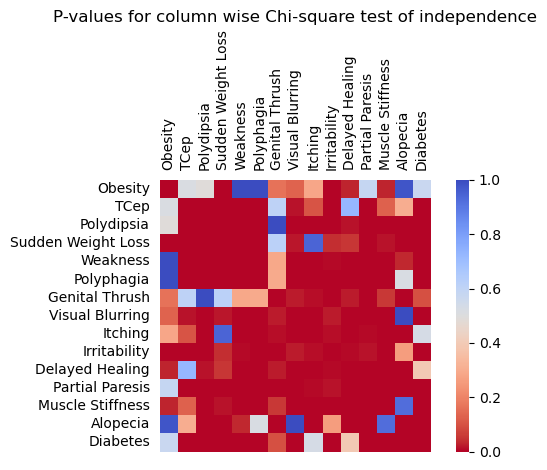

In [26]:
import matplotlib
from helpers import plot_chi_square_p_values

# reverse color as low p-value indicates strong dependence
plot_chi_square_p_values(train[binary_features + ['Diabetes']], kwargs={'cmap' : matplotlib.colormaps[cmap +'_r']})


Common sense can replace domain experts, in some cases - Roxana Pop, i.e. we should not use 'TCep' for our analysis (even though delayed healing might be correlated with aversion for tattoos)


In [27]:
from biseral_correlation import plot_point_biserial_correlation

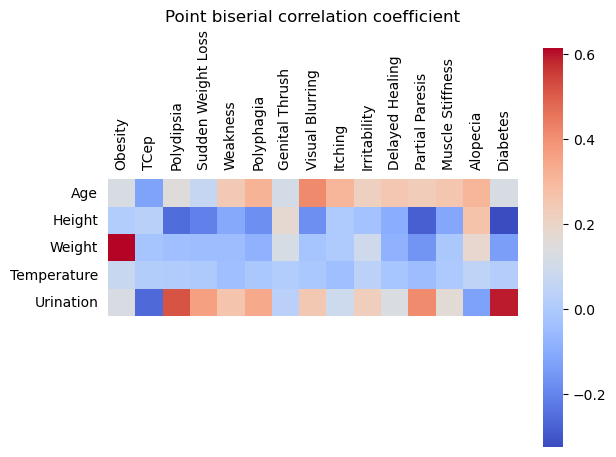

In [28]:
plot_point_biserial_correlation(train, cont=num_features, cat=binary_features + ['Diabetes'], kwargs={'cmap' : cmap})

In [29]:
from helpers import BMI

train['BMI'] = BMI(train['Weight'],  train['Height'])

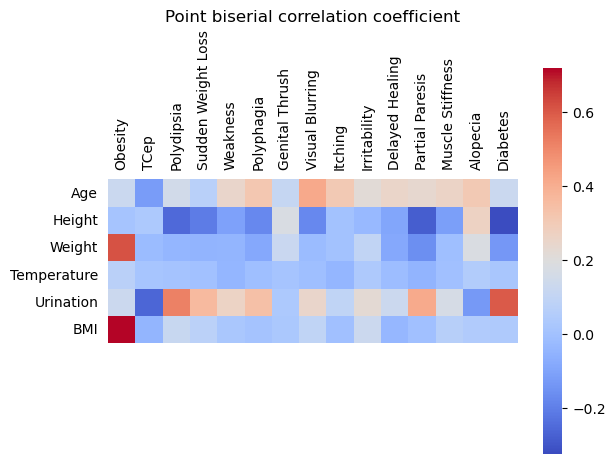

In [30]:
plot_point_biserial_correlation(train, cont=num_features + ['BMI'], cat=binary_features + ['Diabetes'], kwargs={'cmap' : cmap})

 We see that weight and obesity is strongly correlated, however BMI and obesity is not. Furthermore, diabetes has no correlation with either of them. This does not mean that BMI or weight are bad predictors, since the relationship between them could be non-linear. 

 Urination is indeed very correlated, which is apparent in the later plots.

## Data exploration

In [31]:
# There are some interesting things to see in the categoricals ...
# Only one Black in entire data set ...
# This looks very much like a rich person data set ...
for c in cat_features:
  print(train.groupby(c, dropna=False).size())

#print(train['GP'].unique())

Race
Asian        8
Black        1
MISSING      6
White      401
dtype: int64
Occupation
Architect        30
Consultant       35
Dentist          31
Economist        29
Engineer         24
Entrepreneur     23
Journalist       23
Judge            34
Lawyer           25
MISSING          11
Manager          34
Retired         116
Student           1
dtype: int64
GP
Dr. Albie Colon          23
Dr. Alice Watson         24
Dr. Andreea Gregory      23
Dr. Angharad Grainger    21
Dr. Arda O'Brien         20
Dr. Cristiano Ayala      15
Dr. Dominic Farmer       21
Dr. Ingrid Mata          18
Dr. Jamil Walters        18
Dr. Joshua Riley         23
Dr. Kameron Lancaster    22
Dr. Kason Lloyd          19
Dr. Khalid Sellers       23
Dr. Korey Clay           22
Dr. Lina Beech           19
Dr. Lorelai York         18
Dr. Madison Guy          26
Dr. Mayson Harris        16
Dr. Nial Higgs           17
Dr. Orla Arellano        21
MISSING                   7
dtype: int64


Polydipsia
0.0    1.945990
1.0    2.657027
Name: Urination, dtype: float64


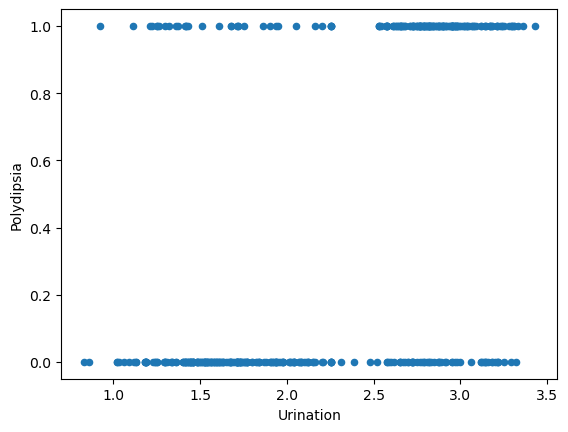

In [32]:
train.plot.scatter('Urination', 'Polydipsia')
print(train.groupby('Polydipsia')['Urination'].mean())

<Axes: ylabel='Frequency'>

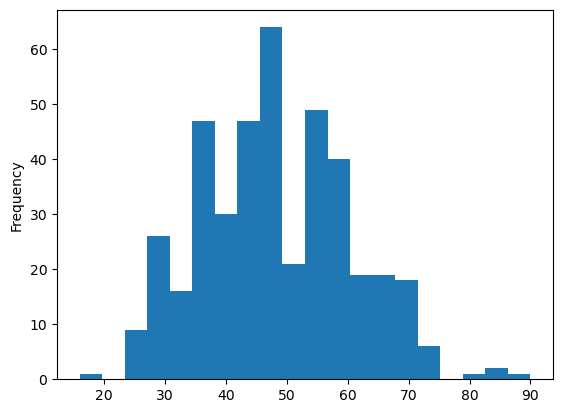

In [33]:
train['Age'].plot.hist(bins=20)

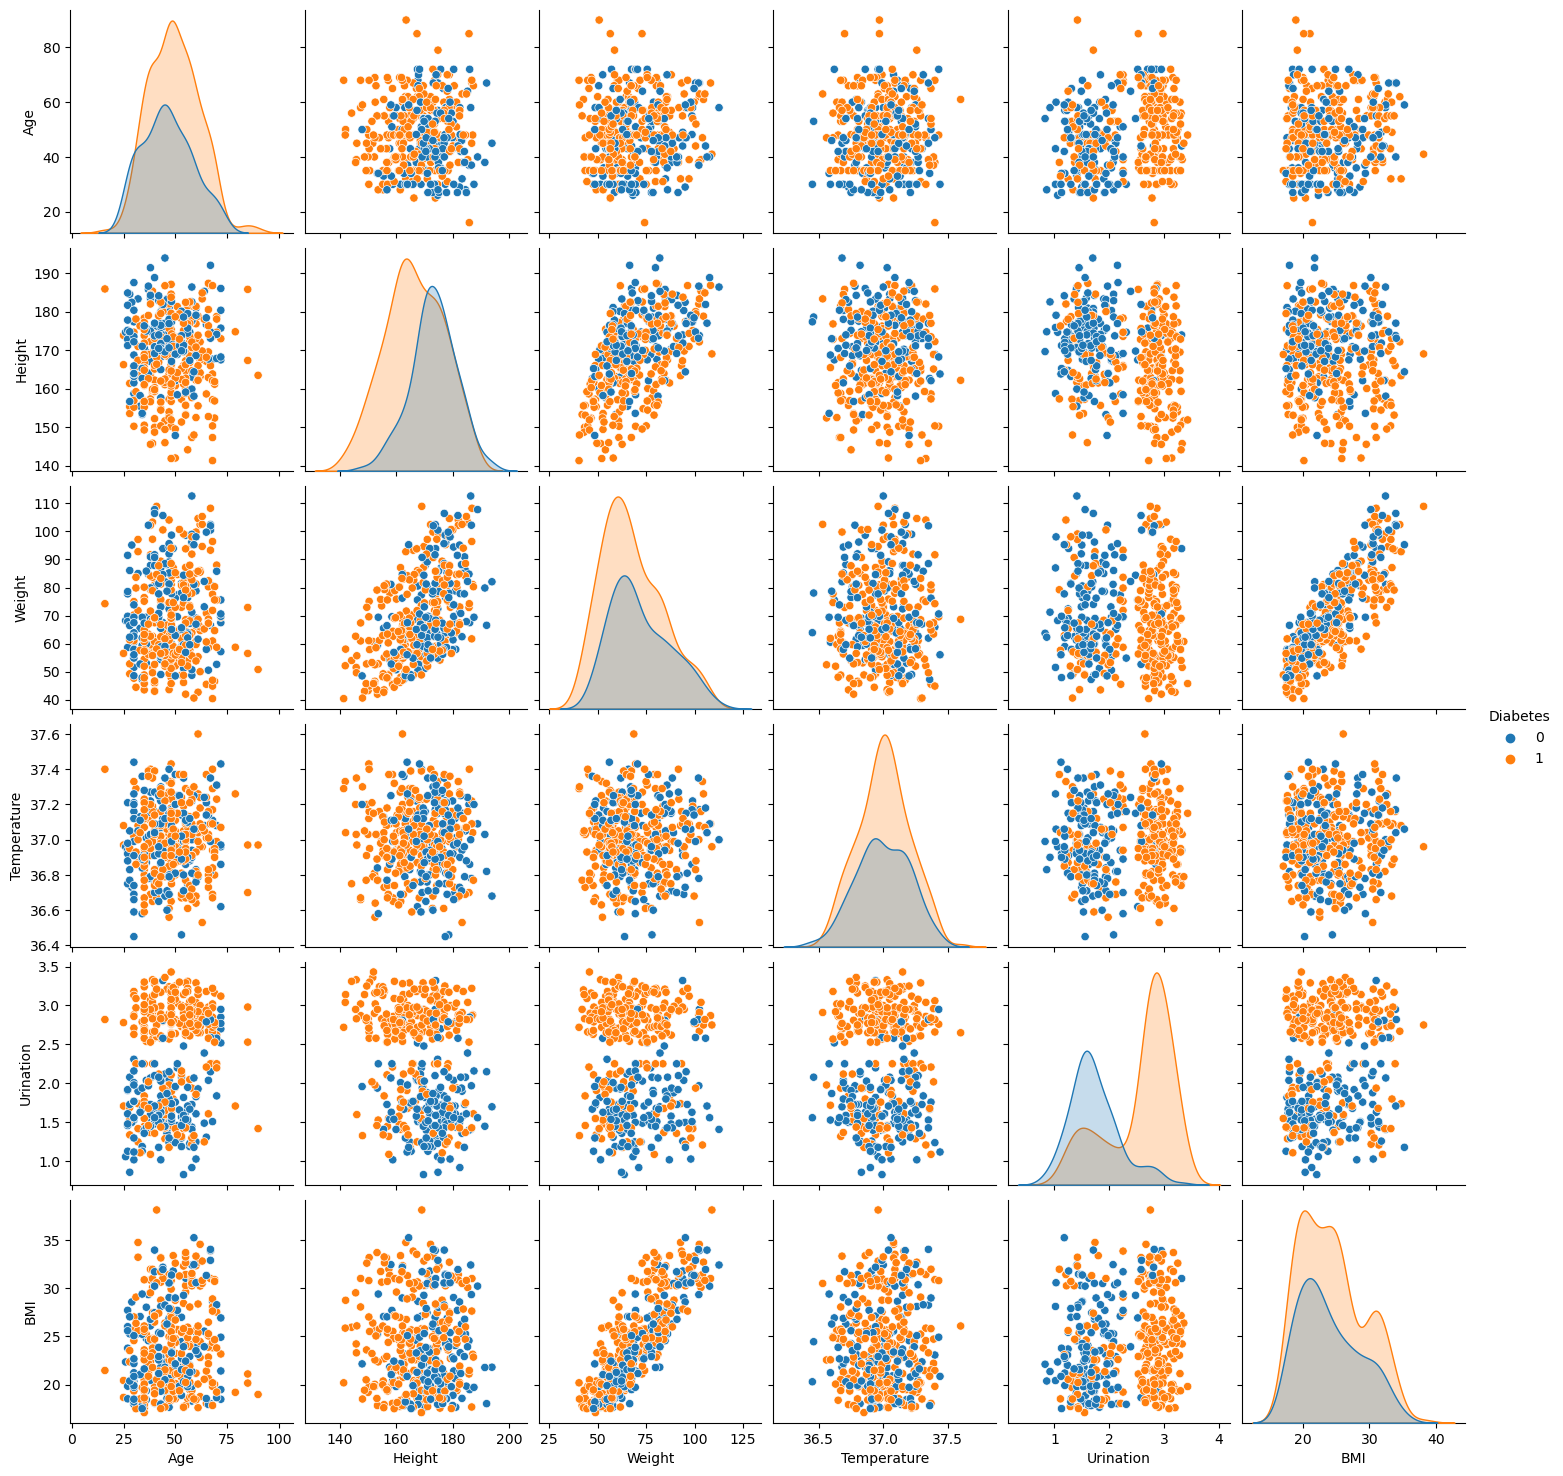

In [47]:
# After encoding, pair-plotting diabetes is messed up, because it tries to make 23*23 plots?
# need to drop the binaries from DF plotted.
# train_plot = train.drop(binary_features , axis=1)
train_plot = train[num_features + ['BMI', 'Diabetes']]

#diabetes_plot = train.drop('Gender', axis=1)
g = sns.pairplot(train_plot, hue='Diabetes')

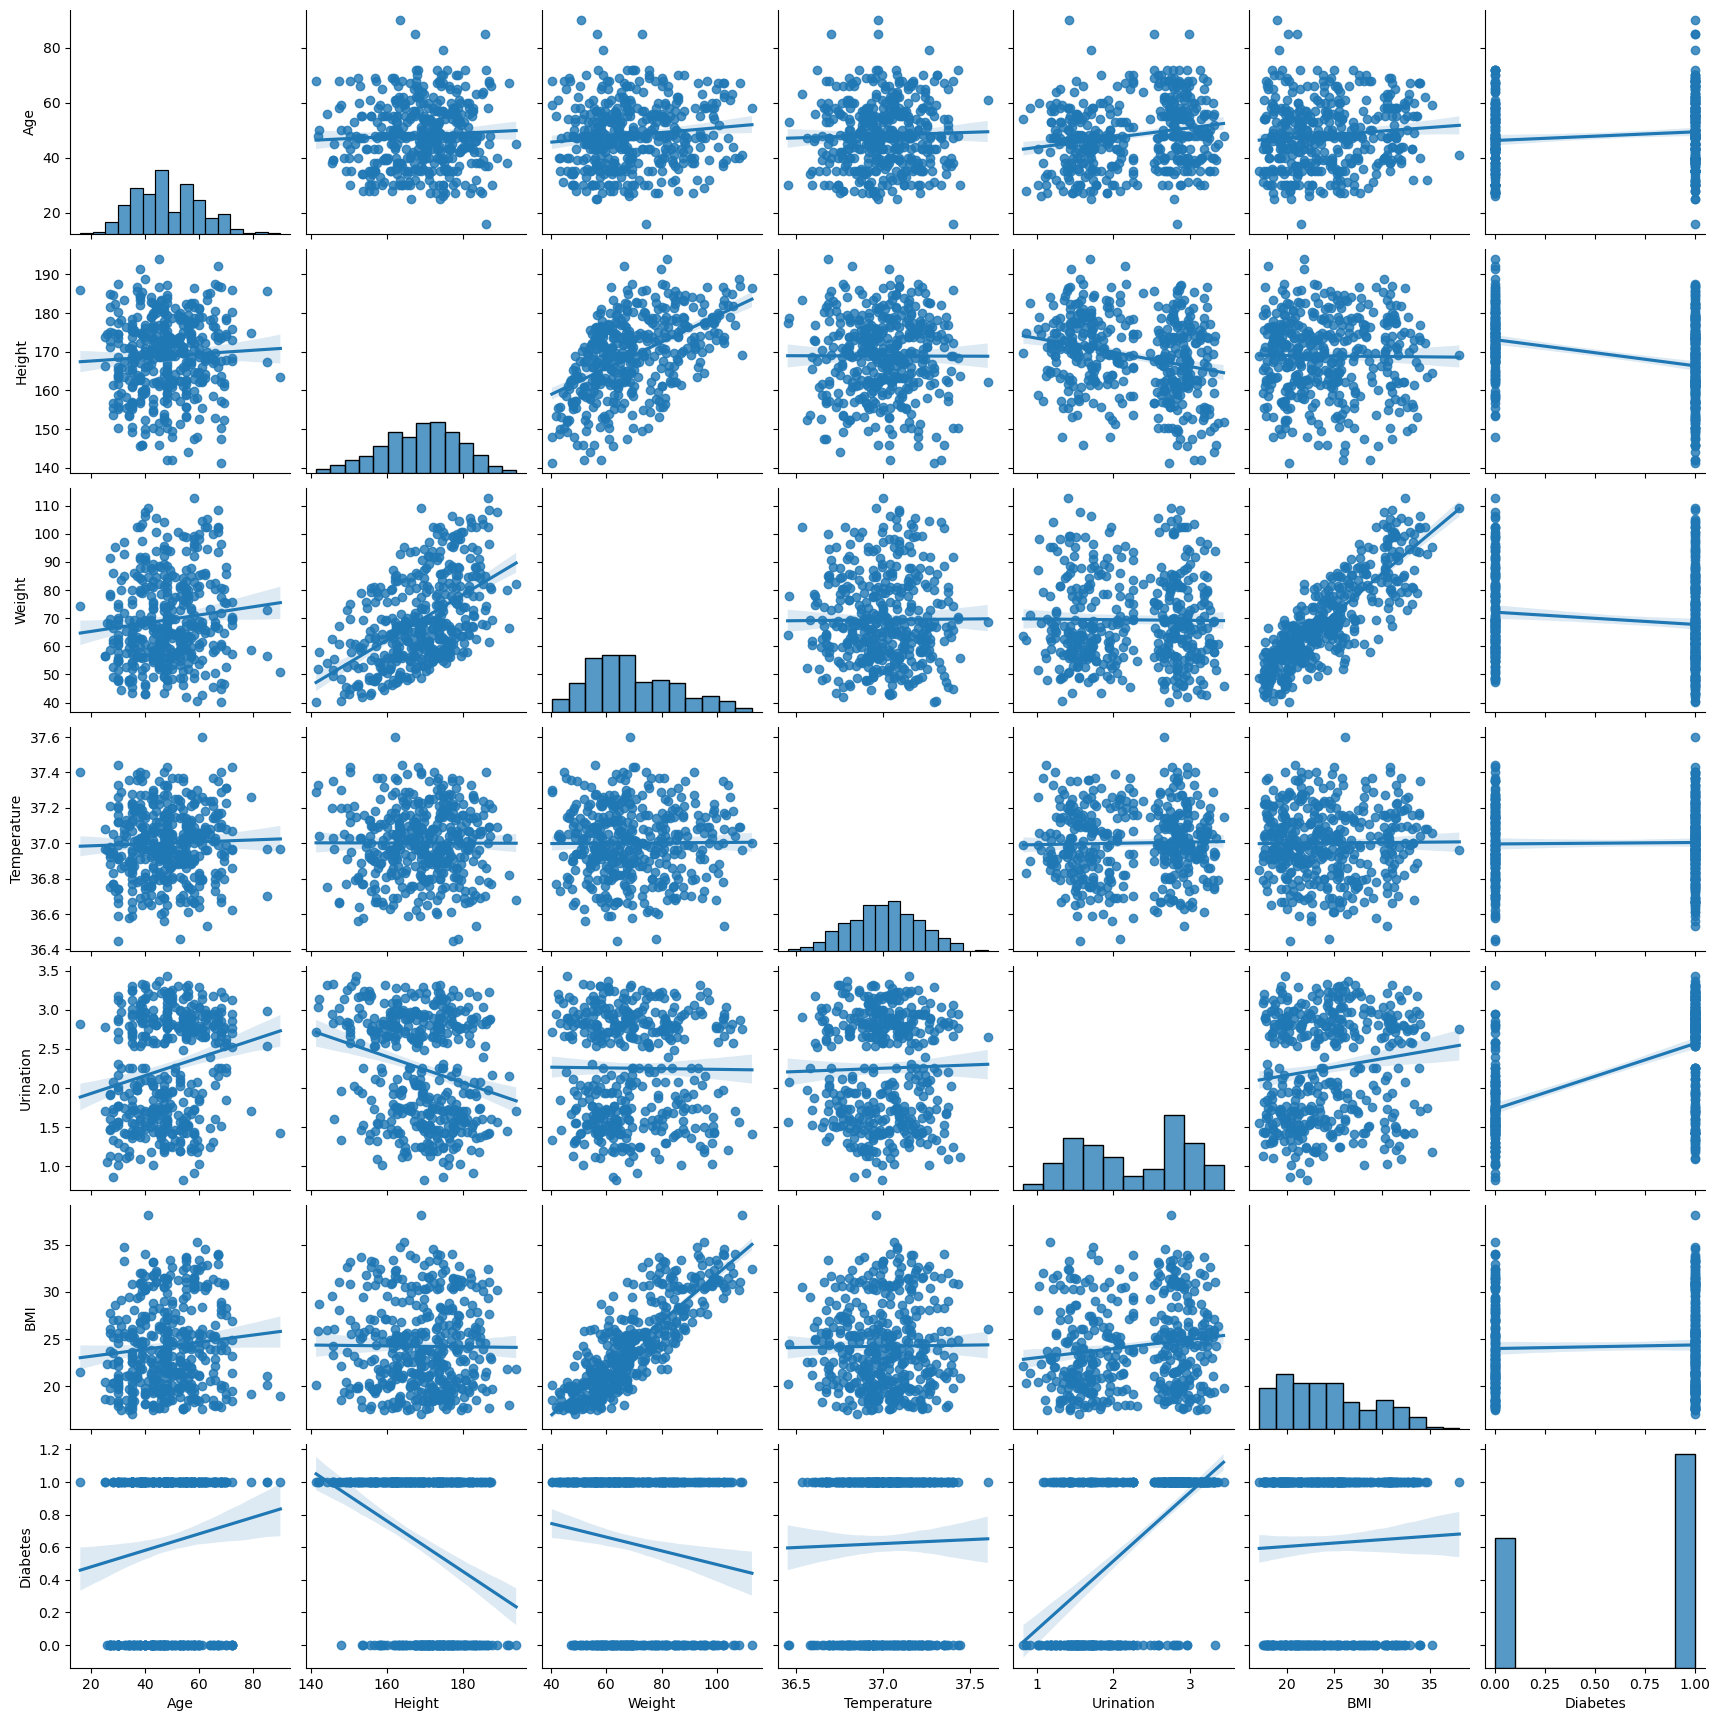

In [48]:
g = sns.pairplot(train_plot, kind='reg')

In [36]:
# Perhaps redundant given the chi-square plot earlier?
for f in binary_features:
  cross_tab = pd.crosstab(diabetes[f], diabetes['Diabetes'], rownames=[f], colnames=['Diabetes'])
  print(cross_tab)
  print('-----------------------')

Diabetes    0    1
Obesity           
0.0       171  264
1.0        25   53
-----------------------
Diabetes    0    1
TCep              
0          54  243
1         146   77
-----------------------
Diabetes      0    1
Polydipsia          
0.0         190   94
1.0           8  222
-----------------------
Diabetes              0    1
Sudden Weight Loss          
0.0                 169  127
1.0                  29  181
-----------------------
Diabetes    0    1
Weakness          
0.0       110  100
1.0        87  218
-----------------------
Diabetes      0    1
Polyphagia          
0.0         151  131
1.0          48  188
-----------------------
Diabetes          0    1
Genital Thrush          
0.0             163  236
1.0              31   82
-----------------------
Diabetes           0    1
Visual Blurring          
0.0              140  144
1.0               58  174
-----------------------
Diabetes    0    1
Itching           
0.0       100  165
1.0        95  154
----------------

# Training model

In [37]:
# Some sanity checks
assert train.isna().sum().sum() == 0, 'No Na-s should be present after handling. They must have been introduced'

#selected_features = ['Urination', 'Age'] + binary_features
selected_features = num_features + binary_features + one_hot_features['Gender'] 
print(selected_features)
print(len(selected_features))

# This is so stupid ... Never mind, Decision tree does not seem to care if X is series or DF ...
# Naive Bayes does, I think ...
#if len(selected_features) == 1:
#  X_train = train2[[selected_features[0]]]
#else:
X_train = train[selected_features]
y_train = train['Diabetes']

# Test set
X_test = test[selected_features]
y_test = test['Diabetes']


for index in X_train.dtypes.keys():
    dtype = X_train.dtypes[index]
    print(index, dtype)
    # Quite ugly and not very felxible test. Should be improved upon
    assert dtype == 'float64' or dtype == 'int64' or dtype == 'uint8', f"feature '{index}' is not of type float or int but {dtype}"


['Age', 'Height', 'Weight', 'Temperature', 'Urination', 'Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness', 'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching', 'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia', 'gender_Male', 'gender_MISSING', 'gender_Female']
22
Age float64
Height float64
Weight float64
Temperature float64
Urination float64
Obesity float64
TCep int64
Polydipsia float64
Sudden Weight Loss float64
Weakness float64
Polyphagia float64
Genital Thrush float64
Visual Blurring float64
Itching float64
Irritability float64
Delayed Healing float64
Partial Paresis float64
Muscle Stiffness float64
Alopecia float64
gender_Male uint8
gender_MISSING uint8
gender_Female uint8


Age : 20.094910123704693
Height : 26.454698514284203
Weight : 26.802112663405012
Temperature : 0.00017964371561501213
Urination : 30.471458223954627
Obesity : 0.41951159530777365
TCep : 54.85956091733016
Polydipsia : 93.03840917793167
Sudden Weight Loss : 38.90253104500506
Weakness : 13.841736660234762
Polyphagia : 25.654599741898352
Genital Thrush : 2.522212190092081
Visual Blurring : 19.386852995400133
Itching : 0.2818696767741354
Irritability : 33.44189263980451
Delayed Healing : 0.5138051088915511
Partial Paresis : 45.594847225420466
Muscle Stiffness : 8.443304853630028
Alopecia : 19.877380771378636
gender_Male : 32.39497056815601
gender_MISSING : 2.4247104247104243
gender_Female : 53.386960954395654


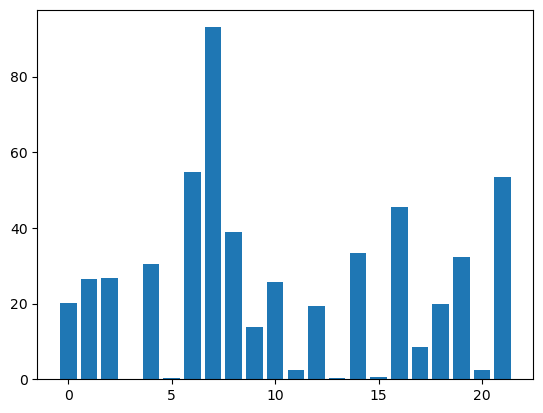

,Age,Height,Weight,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Visual Blurring,Irritability,Partial Paresis,Alopecia,gender_Male,gender_Female
320,65.0,167.15,70.85,3.18,1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,1
298,55.0,160.07,75.86,2.81,0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
276,35.0,175.50,54.11,3.12,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0
247,68.0,167.68,80.55,1.51,1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,0
176,47.0,157.29,49.02,1.55,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,35.0,156.69,47.78,2.68,0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,1
483,55.0,159.16,56.85,1.54,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,1
240,66.0,174.19,67.28,2.90,1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1,0
65,57.0,167.37,59.60,1.67,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,0


In [38]:
from sklearn.feature_selection import SelectKBest, chi2
skb =  SelectKBest(chi2, k=15)
X_new = skb.fit_transform(X_train, y_train)

cols_idxs = skb.get_support(indices=True)
features_df_new = X_train.iloc[:,cols_idxs]



# what are scores for the features
for i in range(len(skb.scores_)):
 print(X_train.columns[i], ":", skb.scores_[i])
# plot the scores
plt.bar([i for i in range(len(skb.scores_))], skb.scores_)
plt.show()
features_df_new

Decision tree with depth=1. cv score: 0.7691910499139414
Decision tree with depth=2. cv score: 0.8459839357429718
Decision tree with depth=3. cv score: 0.8652610441767068
Decision tree with depth=4. cv score: 0.9037578886976476
Decision tree with depth=5. cv score: 0.9109294320137693
Decision tree with depth=6. cv score: 0.9133390705679861
Decision tree with depth=7. cv score: 0.9013482501434307
Decision tree with depth=8. cv score: 0.8868904188181297
Decision tree with depth=9. cv score: 0.8845668387837062
Decision tree with depth=10. cv score: 0.8893000573723466
Decision tree with depth=11. cv score: 0.9061101549053356
Decision tree with depth=12. cv score: 0.8749282845668388
Decision tree with depth=13. cv score: 0.8821285140562249
Decision tree with depth=14. cv score: 0.9060814687320711
Decision tree with depth=15. cv score: 0.8869477911646587
Decision tree with depth=16. cv score: 0.8965863453815259
Decision tree with depth=17. cv score: 0.8772518646012621
Decision tree with dept

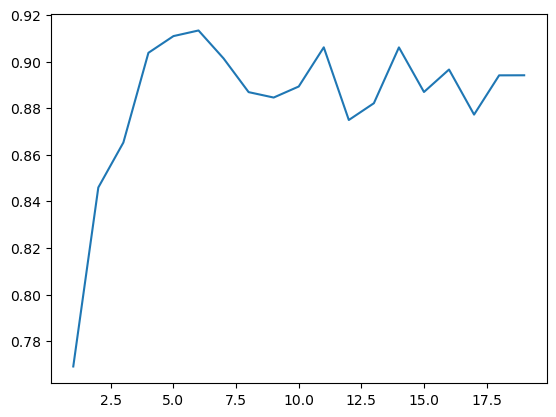

In [39]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

depths = list(range(1, 20))

scores = {}

"""
By weighing misslcassification more severly, we can minimze type II error,
which is desirable in the public health scenario. However, even with
a very skewed weighing (1-100), we still get missclassification,
indicatting that there are 'outliers' in the test set.

Further investigation revealed that they typically where quite old or quite young,
with a typical amount of urination.
"""
weight = {0: 1,
          1:1}

use_weights = False

for d in depths:
    clf_cv = tree.DecisionTreeClassifier(max_depth=d, class_weight=weight if use_weights else None)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Decision tree with depth={d}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())

clf = tree.DecisionTreeClassifier(max_depth=7, class_weight=weight if use_weights else None)
clf = clf.fit(X_train, y_train)

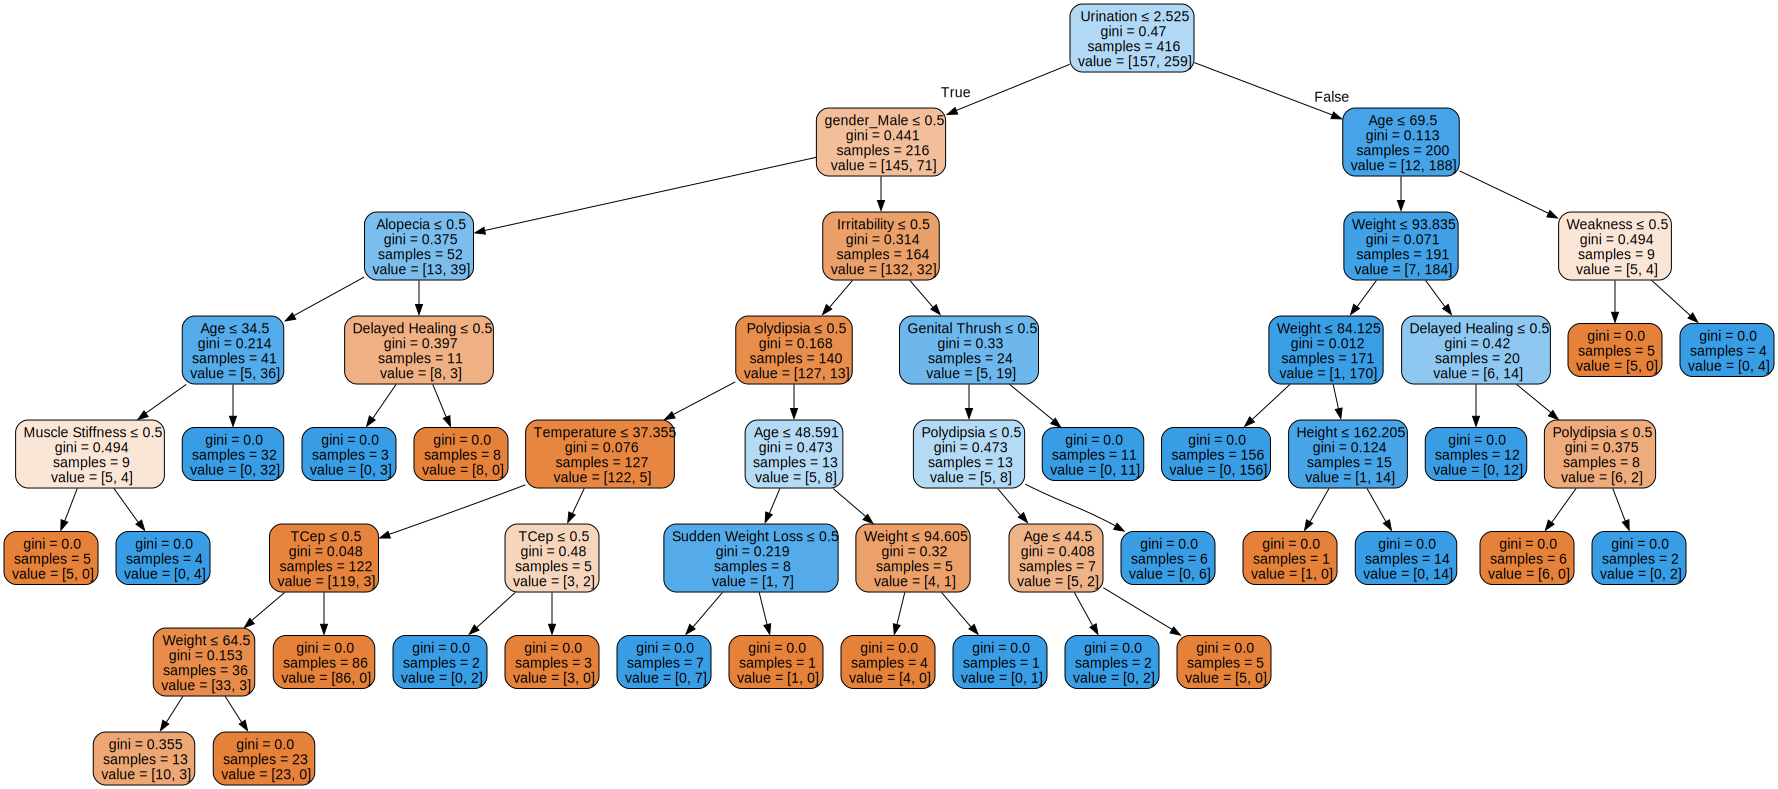

In [40]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None,
                      feature_names=selected_features,
                      #class_names='Diabetes', # this parameter doesen't seem to work
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
# Make Pdf
#graph.render("Diabetes")
graph

In [41]:
# Training accuracy
from sklearn import metrics
y_train_pred = clf.predict(X_train)
metrics.accuracy_score(y_train, y_train_pred)

0.9927884615384616

In [42]:
y_test_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred)

0.9615384615384616

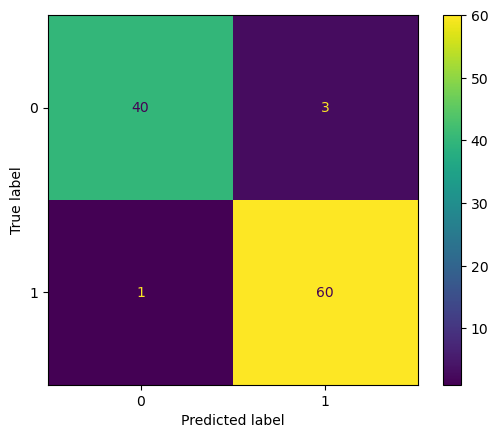

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()

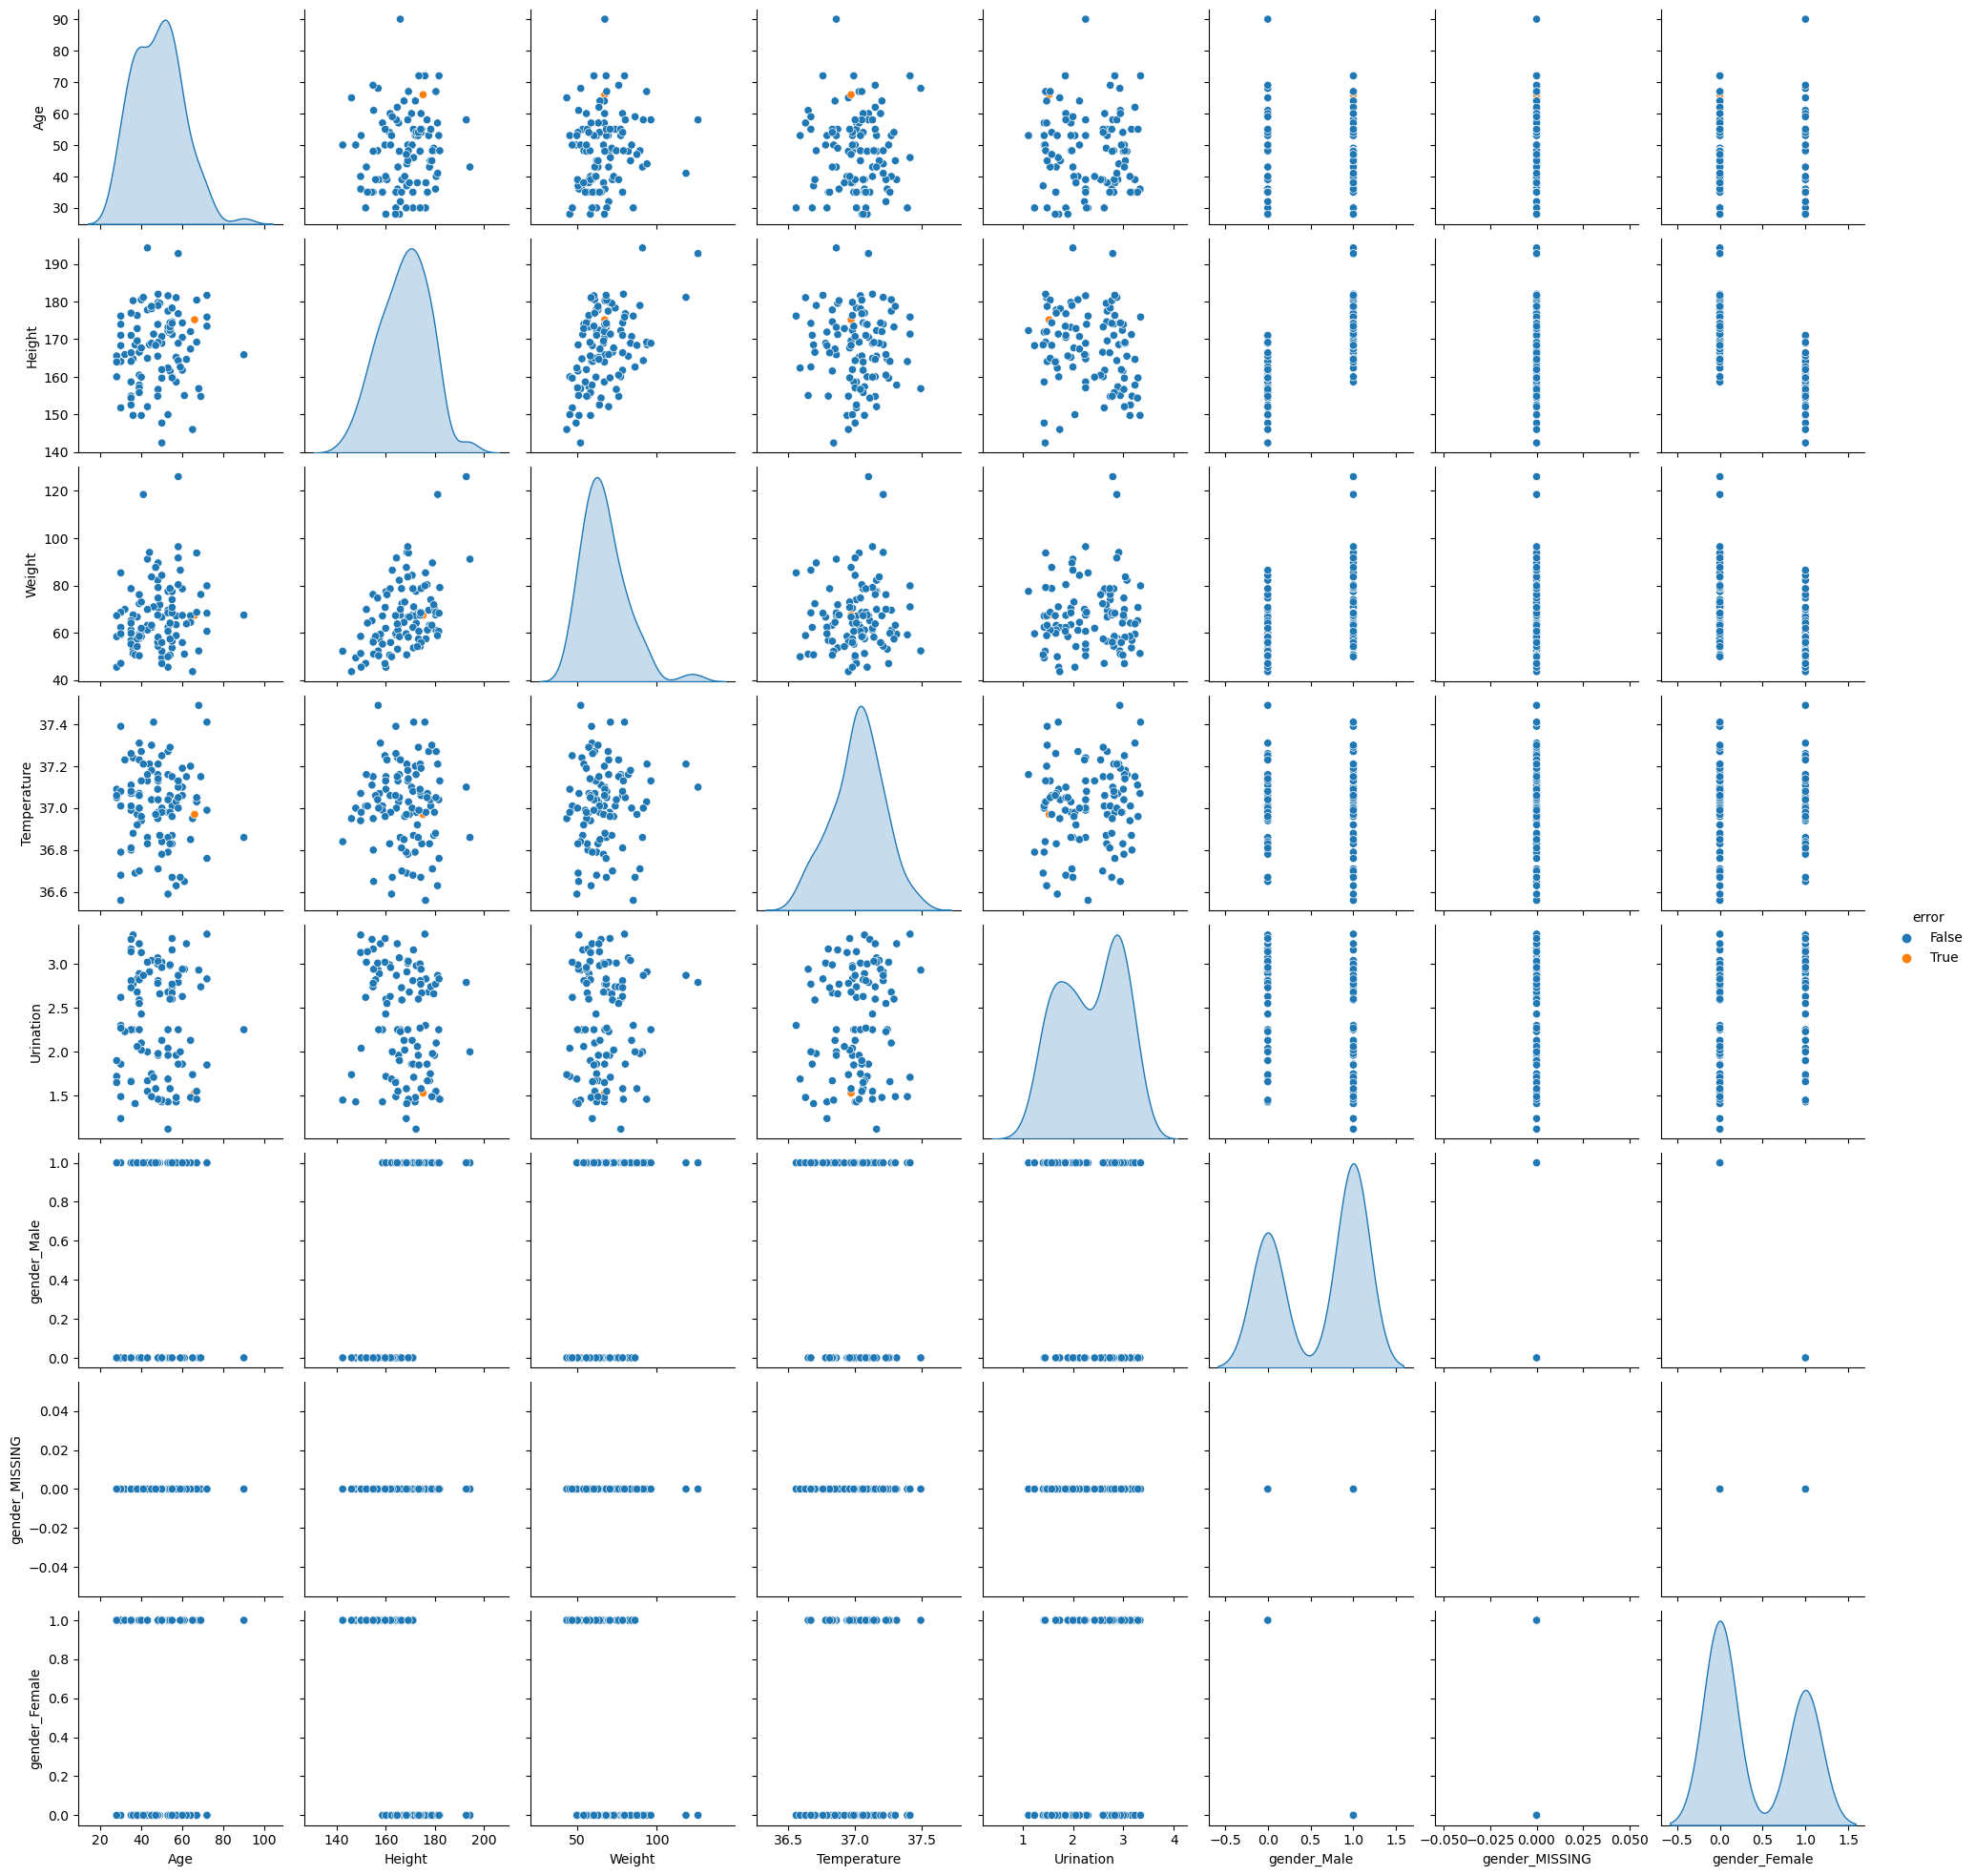

In [44]:
X_test_plot = X_test.copy()
X_test_plot['error'] = y_test > y_test_pred
g = sns.pairplot(X_test_plot.drop(binary_features, axis=1), hue='error')

Logistic regression with C = 10.00. cv score: 0.9157487091222031
Logistic regression with C = 7.85. cv score: 0.9157487091222031
Logistic regression with C = 6.16. cv score: 0.9133677567412507
Logistic regression with C = 4.83. cv score: 0.9157773952954675
Logistic regression with C = 3.79. cv score: 0.9181870338496845
Logistic regression with C = 2.98. cv score: 0.9181870338496845
Logistic regression with C = 2.34. cv score: 0.9181870338496845
Logistic regression with C = 1.83. cv score: 0.9181870338496845
Logistic regression with C = 1.44. cv score: 0.9181870338496845
Logistic regression with C = 1.13. cv score: 0.9229776247848538
Logistic regression with C = 0.89. cv score: 0.9229776247848538
Logistic regression with C = 0.70. cv score: 0.9229776247848538
Logistic regression with C = 0.55. cv score: 0.9205679862306368
Logistic regression with C = 0.43. cv score: 0.9205679862306368
Logistic regression with C = 0.34. cv score: 0.9205679862306368
Logistic regression with C = 0.26. cv s

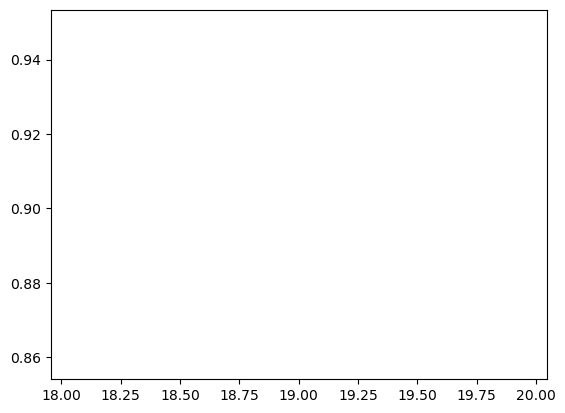

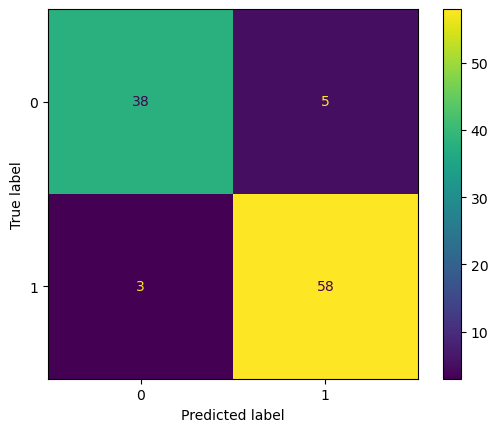

In [45]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1000)

cs = 1/np.geomspace(0.1, 10, 20)

scores = {}


for c in cs:
    clf_cv = LogisticRegression(penalty='l2', solver='liblinear', C=c)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Logistic regression with C = {c:.2f}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())



clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

# Accuracy
print(metrics.accuracy_score(y_test, y_test_pred))
print(clf.coef_)

# Confusion Matrix
confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()


In [46]:
metrics.accuracy_score(y_test, y_test_pred)

0.9230769230769231